# Introduction et problématisation

**À remplir**

### Import des packages utiles

In [2]:
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install geoplot

     |████████████████████████████████| 15.4 MB 118 kB/s 
     |████████████████████████████████| 6.3 MB 50.9 MB/s 
     |████████████████████████████████| 994 kB 30.2 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.0 MB 2.1 MB/s 
     |████████████████████████████████| 10.8 MB 3.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 48.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 48.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 56.4 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516293 sha256=2f78438005c16a752256e26f2e61c80c7ebc8c802f80d208b388edc0045e307e


In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import geoplot
import folium
from IPython.core.display import display, HTML
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly.express as px
import folium.plugins as plugins

# Récupération et traitement des données

Nous allons commencer par récupérer les données qui seront utiles à notre analyse des tournages de la ville de Paris. Notre base de données principale vient du site Paris Data. Ce site fournit des données publiques de la ville de Paris, elles ont été mis en ligne dans une démarche d'innovation ouverte menée par la Ville de Paris depuis 2008.

Notre base de données inventorie les lieux de tournage de film à Paris depuis 2016. Les tournages désignent les longs métrages, les séries et les téléfilms, réalisés à l’extérieur. Les lieux de tournage de l’année en cours ne sont pas diffusés. Depuis 2017, les informations sont issues de l’application AGATE, application d'instruction des demandes de tournage utilisée par la Mission Cinéma. La dernière mise à jour de ce jeu de données date de février 2021. Les différents attributs de notre dataframe sont :

- Identifiant du lieu → Type : texte, Exemple : 2018-1367
- Année du tournage	→ Type : date, Exemple : 2017
- Type de tournage → Type : texte, Exemple : Long métrage
- Titre	: Type → texte, Exemple : Le Bazar de la Charité
- Réalisateur → Type : texte, Exemple : Alexandre Laurent
- Producteur → Type : texte, Exemple : TAMARA FILMS
- Localisation de la scène → Type : texte, Exemple : 20 rue saint-ambroise, 75011 paris
- Code postal → Type : texte, Exemple : 75011
- Date de début → Type : date, Exemple : 2018-11-23
- Date de fin → Type : date, Exemple : 2019-01-14
- Coordonnée en X → Type : float, Exemple : 2.37826457
- Coordonnée en Y → Type : float, Exemple : 48.86249945
- geo_shape : Type → geo_shape, Exemple : {"coordinates":[2.378264569220881,48.862499453812575],"type":"Point"}
- geo_point_2d : Type → geo_point_2d, Exemple : [48.8624994538,2.37826456922]

Les coordonnées qui nous serviront le plus sont le type de tournage, le code postal, l'année de tournage ou encore les coordonnées en X et Y (latitude, longitude).

Voici à quoi ressemble notre base de données :

In [8]:
df = pd.read_csv('lieux-de-tournage-a-paris-csv.csv',sep=";",engine='python')
df.head()

,Identifiant du lieu,Année du tournage,Type de tournage,Titre,Réalisateur,Producteur,Localisation de la scène,Code postal,Date de début,Date de fin,Coordonnée en X,Coordonnée en Y,geo_shape,geo_point_2d
0,2019-173,2019,Long métrage,IBRAHIM,SAMIR GUESMI,WHY NOT PRODUCTIONS,"29 boulevard auguste blanqui, 75013 paris",75013.0,2019-02-22,2019-02-22,2.352559,48.830116,"{""type"": ""Point"", ""coordinates"": [2.3525586756...","48.8301164772,2.3525586756"
1,2019-176,2019,Série TV,Le Bazar de la Charité,Alexandre Laurent,quad fantastico télévisons Le bazar de la Charité,"21 rue gracieuse, 75005 paris",75005.0,2019-03-04,2019-03-04,2.351335,48.842919,"{""type"": ""Point"", ""coordinates"": [2.3513345620...","48.8429193101,2.35133456201"
2,2019-515,2019,Série TV,PLATANE SAISON 3,ERIC JUDOR,4 MECS EN BASKETS,"9 avenue hoche, 75008 paris",75008.0,2019-05-20,2019-05-20,2.303760,48.877212,"{""type"": ""Point"", ""coordinates"": [2.3037596788...","48.8772122978,2.30375967881"
3,2019-522,2019,Série TV,The Eddy,Damien Chazelle,atlantique productions,"28 boulevard jourdan, 75014 paris",75014.0,2019-05-23,2019-05-24,2.334607,48.821424,"{""type"": ""Point"", ""coordinates"": [2.3346071504...","48.8214241259,2.33460715041"
4,2018-819,2018,Série TV,Munch saison 2,frederic Berthe,EXILENE,"rue thomas mann, 75013 paris",75013.0,2018-07-13,2018-07-13,2.378161,48.829173,"{""type"": ""Point"", ""coordinates"": [2.3781606591...","48.8291726829,2.37816065911"


# I. Que nous dit notre base de données sur les tournages dans la ville de Paris ?

Nous allons dans un premier temps analyser et décrire notre base de données, en essayant d'extraire un maximum d'informations utiles.

## I.1. Traitement initial des données

In [9]:
print("Nombre de tournages total: ",df['Identifiant du lieu'].count())

Nombre de tournages total:  8919


Notre base de données contient 8919 tournages. On remarque que de mêmes films et séries sont tournés à différents endroits et représentent donc plusieurs lignes de notre base de données. Nous pouvons alors nous demander combien de films et séries sont réellement présents dans cette base de données.

In [10]:
print("Nombre de séries/films différents : ",df['Titre'].nunique())
print("Nombre de types de tournage : ",df['Type de tournage'].nunique())

Nombre de séries/films différents :  1055
Nombre de types de tournage :  4


Il y a 1055 films et séries différents dans notre jeu de données.

On remarque également qu'il existe un nombre fini de types de tournage différents. Ils sont au nombre de 4 :
- Long métrage
- Série TV
- Série Web
- Téléfilm

### I.1.a. Étude des valeurs manquantes

Commençons par traiter les valeurs manquantes. Si notre base comporte des valeurs manquantes, nous voulons savoir quelles sont-elles et si nous devons les éliminer.

In [11]:
df.isnull().sum()

Identifiant du lieu           0
Année du tournage             0
Type de tournage              0
Titre                         0
Réalisateur                 221
Producteur                   12
Localisation de la scène      0
Code postal                   1
Date de début                 0
Date de fin                   0
Coordonnée en X               0
Coordonnée en Y               0
geo_shape                     0
geo_point_2d                  0
dtype: int64

Nous voulons savoir si les films ayant des données manquantes ont des caractéristiques similaires.

In [12]:
dfNaN = df[pd.isnull(df['Producteur'])]
dfNaN[['Titre','Année du tournage','Code postal','Type de tournage']].head()

,Titre,Année du tournage,Code postal,Type de tournage
55,TOUT LE MONDE DEBOUT,2017,75008.0,Long métrage
770,Tournage Web Série Frustration Ep 8,2017,75018.0,Série Web
1085,MATIERE GRISE,2018,75016.0,Série Web
1209,Mathieu et Thomas au bord de la crise de nerf,2018,75017.0,Série TV
1452,Marcus et Mercier,2018,75012.0,Série TV


In [13]:
dfNaN_2 = df[pd.isnull(df['Réalisateur'])]
dfNaN_2[['Titre','Année du tournage','Code postal','Type de tournage']].head()

,Titre,Année du tournage,Code postal,Type de tournage
31,SKAM SAISON 5 ET 6 SEMAINE 7 SUR 9,2019,75008.0,Série Web
35,D'après une histoire vraie,2017,75008.0,Long métrage
38,Un cadeau du ciel,2017,75003.0,Long métrage
100,LEBOWITZ CONTRE LEBOWITZ 2,2017,75116.0,Série TV
101,LEBOWITZ CONTRE LEBOWITZ 2,2017,75010.0,Série TV


In [14]:
dfNaN_2.groupby('Type de tournage')["Identifiant du lieu"].agg([pd.Series.count])

,count
Type de tournage,
Long métrage,85
Série TV,91
Série Web,44
Téléfilm,1


In [15]:
dfNaN_2.groupby('Année du tournage')["Identifiant du lieu"].agg([pd.Series.count])

,count
Année du tournage,
2017,93
2018,70
2019,57
2020,1


In [16]:
dfNaN_2.groupby('Code postal')["Identifiant du lieu"].agg([pd.Series.count]).head()

,count
Code postal,
75001.0,18
75002.0,2
75003.0,5
75004.0,17
75005.0,7


In [17]:
df_titre = dfNaN_2.groupby('Titre')["Identifiant du lieu"].agg([pd.Series.count])
df_titre[df_titre["count"]>10]

,count
Titre,
DIX POUR CENT SAISON 3,13
DIX POUR CENT SAISON 3,15
PRODUCTION 46,19
Un homme pressé,12


On ne remarque pas de grandes similitudes entre les films et séries ayant des valeurs manquantes. On peut tout de même noter que 4 films/séries ont une valeur manquante qui compte pour plus de 10 occurrences.

Les données manquantes ne portent que sur des noms de réalisateurs et producteurs. Ces attributs ne sont pas utiles à notre étude, il n'est donc pas nécessaire d'éliminer les films associés. Nous pensons qu'il n'est pas utile de réduire notre base de données si cela nécessaire.

### I.1.b. Étude sur les producteurs et réalisateurs

Par la suite, nous pouvons étudier de plus près quelques caractéristiques de la base de données, comme le producteur ayant tourné dans le plus de lieux ou encore le plus grand nombre de tournages d'un réalisateur. 

In [18]:
# Le producteur ayant tourné dans le plus de lieux et le nombre de lieux associés 
g=0
for i in df['Producteur']:
    if df['Identifiant du lieu'][df['Producteur']==i].count()>g:
        g=df['Identifiant du lieu'][df['Producteur']==i].count()
        j=i
print("Le producteur",j,"a tourné à",g,"endroits différents.")

Le producteur FIRSTEP a tourné à 188 endroits différents.


In [19]:
#Le réalisateur ayant tourné dans le plus de lieux et le nombre de lieux associés
g=0
for i in df['Réalisateur']:
    if df['Identifiant du lieu'][df['Réalisateur']==i].count()>g:
        g=df['Identifiant du lieu'][df['Réalisateur']==i].count()
        j=i
print("Le réalisateur",j,"a tourné à",g,"endroits différents.")

Le réalisateur ADITYA CHOPRA a tourné à 129 endroits différents.


### I.1.c. Corrélation entre les différentes variables

Nous pouvons étudier la corrélation entre nos variables numériques avec une heatmap.

In [20]:
df['Année du tournage'] = df['Année du tournage'].astype(float) #conversion de date en float
dfC = df[['Année du tournage','Code postal','Coordonnée en X','Coordonnée en Y']]

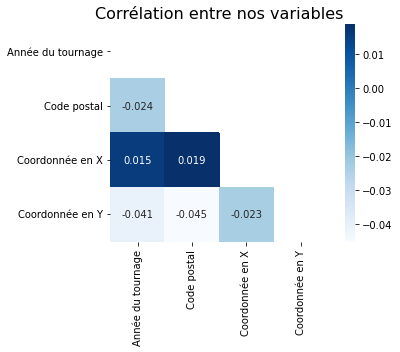

In [21]:
corrMatrice = dfC.corr()
matrice = np.triu(corrMatrice)
sns.heatmap(corrMatrice, annot = True,square = True, mask = matrice, cmap='Blues')
plt.title('Corrélation entre nos variables', fontsize = 16)
plt.show()

**A ANALYSER**

**Etudier d'autres aspects?**

## I.2. Visualisation des données

On va commencer par visualiser nos données sur une carte et étudier plus en détails l'aspect localisation de nos tournages.

In [22]:
coord_X = df['Coordonnée en X'] #latitude
coord_Y = df['Coordonnée en Y'] #longitude

On remarque qu'il y a une erreur sur 2 lignes de notre base de données. La coordonnée en Y est de la forme 48000 au lieu de 48.000. On rectifie cette erreur :

In [23]:
errors = df.loc[df['Coordonnée en Y']>50].index
df.at[errors[0],'Coordonnée en Y'] = df.at[errors[0],'Coordonnée en Y']/1000
df.at[errors[1],'Coordonnée en Y'] = df.at[errors[1],'Coordonnée en Y']/1000

IndexError: ignored

### I.2.a. Représentation cartographique des tournages dans la ville de Paris

On peut désormais représenter graphiquement nos données. On importe les packages utiles.

In [24]:
import requests
import tempfile
import zipfile

url = 'https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12'
temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open("{}/{}.zip".format(dirname, destname), 'wb').write(myfile.content)
  with zipfile.ZipFile("{}/{}.zip".format(dirname, destname), 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

In [25]:
download_unzip(url)
communes = gpd.read_file(temporary_location + "/borders/communes-20190101.json")

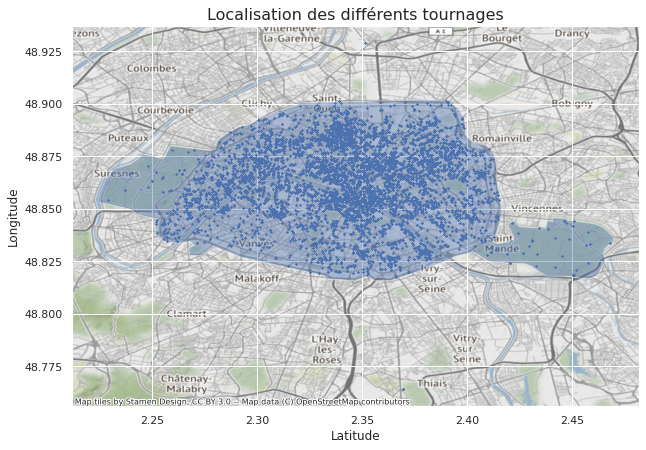

In [26]:
paris = communes[communes.insee.str.startswith("75")]

sns.set()

fig,ax = plt.subplots(figsize = (13,7))
paris.plot(ax = ax, alpha=0.4)
plt.scatter(coord_X,coord_Y,s=2,c='b',marker='x')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Localisation des différents tournages',fontsize=16)
ctx.add_basemap(ax, crs = paris.crs.to_string())
plt.show()

Nous retrouvons bien la carte de Paris qui se dessine avec les localisations de nos tournages. On constate que certains tournages de notre base de données sont excentrés par rapport à Paris. On peut ensuite représenter ces mêmes tournages mais en les différenciant par type.

### I.2.b. Représentation cartographique des tournages dans la ville de Paris par type de tournage

In [27]:
# Nombre de tournages par type de tournage
df.groupby('Type de tournage')["Code postal"].count()

Type de tournage
Long métrage    5013
Série TV        3056
Série Web        380
Téléfilm         469
Name: Code postal, dtype: int64

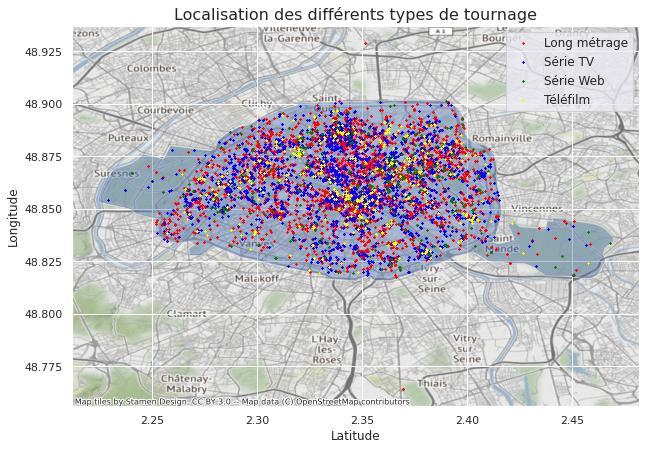

In [28]:
#Mettre carte en dessous

long_metrage = df[df['Type de tournage'].str.startswith("Long métrage")]
serie_tv = df[df['Type de tournage'].str.startswith("Série TV")]
serie_web = df[df['Type de tournage'].str.startswith("Série Web")]
telefilm = df[df['Type de tournage'].str.startswith("Téléfilm")]

X_long_metrage = long_metrage['Coordonnée en X']
Y_long_metrage = long_metrage['Coordonnée en Y']

X_serie_tv = serie_tv['Coordonnée en X']
Y_serie_tv = serie_tv['Coordonnée en Y']

X_serie_web = serie_web['Coordonnée en X']
Y_serie_web = serie_web['Coordonnée en Y']

X_telefilm = telefilm['Coordonnée en X']
Y_telefilm = telefilm['Coordonnée en Y']

fig,ax = plt.subplots(figsize = (13,7))
paris.plot(ax = ax, alpha=0.4)
plt.scatter(X_long_metrage,Y_long_metrage,s=2,c='red',marker='x',label='Long métrage')
plt.scatter(X_serie_tv,Y_serie_tv,s=2,c='blue',marker='x',label='Série TV')
plt.scatter(X_serie_web,Y_serie_web,s=2,c='green',marker='x',label='Série Web')
plt.scatter(X_telefilm,Y_telefilm,s=2,c='yellow',marker='x',label='Téléfilm')
plt.title('Localisation des différents types de tournage',fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
ctx.add_basemap(ax, crs = paris.crs.to_string())
plt.show()

Il y a beaucoup plus de longs métrages (rouge) et séries TV (bleu) dans notre base de données.

### I.2.c. Caractéristiques des films en fonction de leur année de tournage

Les années de tournage étant données, nous pouvons étudier le nombre de tournages par année.

In [29]:
df.groupby('Année du tournage')['Identifiant du lieu'].nunique()

Année du tournage
2016.0    2660
2017.0    1743
2018.0    1579
2019.0    1760
2020.0    1177
Name: Identifiant du lieu, dtype: int64

Nous avons plus de films et séries tournés en 2016 dans notre base de données. Cela peut peut-être s'expliquer par le fait que le jeu de données ait été créé en 2016, la personne l'ayant créée aurait fait plus de recherches pour démarrer sa base de données que lors des mises à jour de 2017 à 2020.

#### Visualisation du nombre de tournage en fonction de leur année et du type de tournage

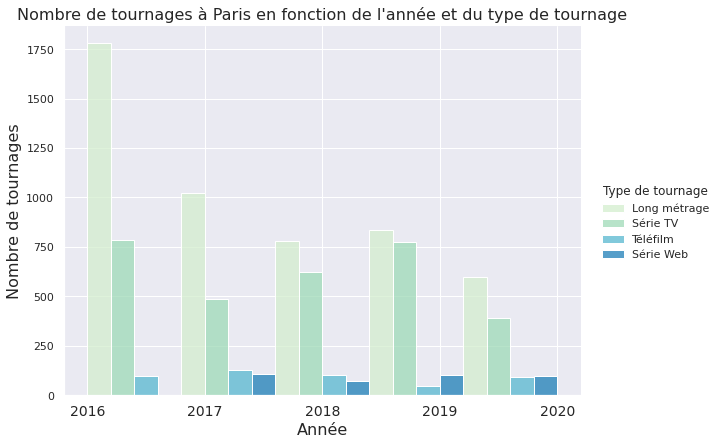

In [30]:
fig = sns.displot(data=df, x='Année du tournage', kind='hist',height=6, aspect=1.4,bins=5,hue='Type de tournage',multiple='dodge', palette='GnBu')
plt.xlabel('Année', fontsize=16)
plt.ylabel('Nombre de tournages', fontsize=16)
plt.xticks(np.arange(2016, 2021, 1))
plt.xticks(fontsize=14)
plt.title("Nombre de tournages à Paris en fonction de l'année et du type de tournage", fontsize = 16)
plt.show()

On remarque qu'en 2016, il n'y pas de Série Web recensée dans notre base de données. Cela est sûrement dû au fait que les séries Web ont commencé à se démocratiser à partir de 2016.

**Analyser plus!!**

### I.2.d. Création d'une variable Arrondissement et étude du nombre de tournages en fonction de l'arrondissement

On va maintenant créer une variable Arrondissement à partir de notre attribut Code postal. Cette variable nous sera utile pour effectuer des études par arrondissement. Les arrondissements correspondent aux trois derniers chiffres des codes postaux. Le code postal étant de type texte, on doit au préalable le convertir en float. D'autre part, certains tournages ont eu lieu en dehors du département 75 (comme nous l'avons constaté précédemment), il nous faut alors exclure ces tournages pour la création de la variable Arrondissement. Pour cela, on va créer un nouveau dataframe df_paris.

In [31]:
# 'float' to 'String' type
df['Code postal'] = df['Code postal'].astype(str)
df_paris = df[df['Code postal'].str.startswith("75")]
df_paris = df_paris.assign(Arrondissement=df_paris.iloc[0:len(df_paris),7].str[3:5].astype(float))
df_paris.head()

,Identifiant du lieu,Année du tournage,Type de tournage,Titre,Réalisateur,Producteur,Localisation de la scène,Code postal,Date de début,Date de fin,Coordonnée en X,Coordonnée en Y,geo_shape,geo_point_2d,Arrondissement
0,2019-173,2019.0,Long métrage,IBRAHIM,SAMIR GUESMI,WHY NOT PRODUCTIONS,"29 boulevard auguste blanqui, 75013 paris",75013.0,2019-02-22,2019-02-22,2.352559,48.830116,"{""type"": ""Point"", ""coordinates"": [2.3525586756...","48.8301164772,2.3525586756",13.0
1,2019-176,2019.0,Série TV,Le Bazar de la Charité,Alexandre Laurent,quad fantastico télévisons Le bazar de la Charité,"21 rue gracieuse, 75005 paris",75005.0,2019-03-04,2019-03-04,2.351335,48.842919,"{""type"": ""Point"", ""coordinates"": [2.3513345620...","48.8429193101,2.35133456201",5.0
2,2019-515,2019.0,Série TV,PLATANE SAISON 3,ERIC JUDOR,4 MECS EN BASKETS,"9 avenue hoche, 75008 paris",75008.0,2019-05-20,2019-05-20,2.303760,48.877212,"{""type"": ""Point"", ""coordinates"": [2.3037596788...","48.8772122978,2.30375967881",8.0
3,2019-522,2019.0,Série TV,The Eddy,Damien Chazelle,atlantique productions,"28 boulevard jourdan, 75014 paris",75014.0,2019-05-23,2019-05-24,2.334607,48.821424,"{""type"": ""Point"", ""coordinates"": [2.3346071504...","48.8214241259,2.33460715041",14.0
4,2018-819,2018.0,Série TV,Munch saison 2,frederic Berthe,EXILENE,"rue thomas mann, 75013 paris",75013.0,2018-07-13,2018-07-13,2.378161,48.829173,"{""type"": ""Point"", ""coordinates"": [2.3781606591...","48.8291726829,2.37816065911",13.0


On observe bien notre nouvelle colonne "Arrondissement". On peut observer le nombre de tournages par arrondissement et le représenter graphiquement.

#### Représentations graphiques du nombre de tournages par arrondissement

In [32]:
# Nombre de tournages par arrondissement
df_arrondissement = df_paris.groupby('Arrondissement')["Code postal"].agg([pd.Series.count])
df_arrondissement.head()

,count
Arrondissement,
1.0,497
2.0,219
3.0,164
4.0,497
5.0,469


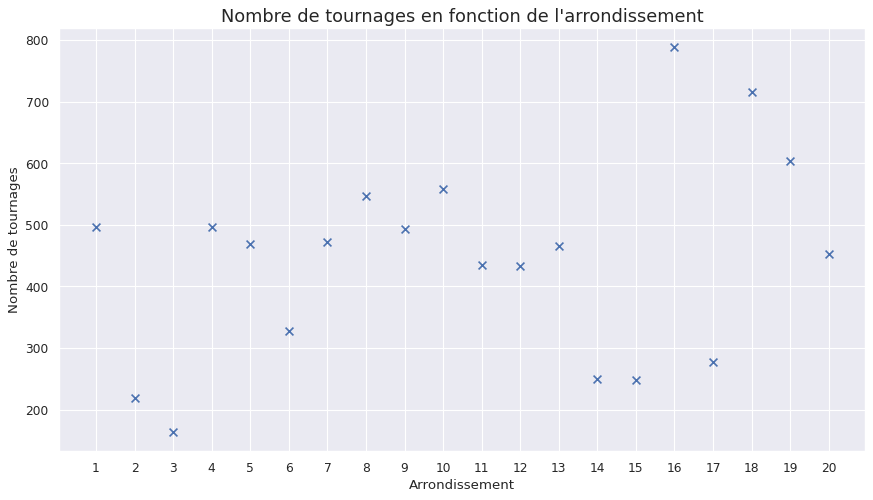

In [33]:
df_nbtournage = df_paris.groupby('Arrondissement')["Identifiant du lieu"].count()

nb_tournages = df_nbtournage.tolist()
arrondissement = [i for i in range(1,21)]

figure = plt.figure(figsize=(13, 7), dpi=80)
plt.scatter(arrondissement,nb_tournages,c='b',marker='x',s=50)
plt.xlabel('Arrondissement')
plt.grid(True)
plt.xticks(arrondissement)
plt.ylabel('Nombre de tournages')
plt.title("Nombre de tournages en fonction de l'arrondissement",fontsize=16)
plt.show()

In [57]:

#fonction pour afficher la carte sur git
def folium_deepnote_show(m):
    data = m.get_root().render()
    data_fixed_height = data.replace('width: 100%;height: 100%', 'width: 100%').replace('height: 100.0%;', 'height: 609px;', 1)
    m.fit_bounds([sw, ne])
    display(HTML(data_fixed_height))

# Dataframe du nombre de tournages par arrondissement
df1 = pd.DataFrame({
    "Arrondissement" : list(range(1,21)), 
    "count" : df_paris.groupby('Arrondissement')["Code postal"].count()
})

#calcul du centre de la fenêtre
center = df[['Coordonnée en Y', 'Coordonnée en X']].mean().values.tolist()
#print(center)

#création de la carte et application du centre 
c = folium.Map(location=center)
c.save('maCarte1.html')

#définition des coins sud-ouest et nord-est de la fenetre
sw = df[['Coordonnée en Y', 'Coordonnée en X']].min().values.tolist()
ne = df[['Coordonnée en Y', 'Coordonnée en X']].max().values.tolist()
#print(sw)

#application à la carte
c.fit_bounds([sw, ne])

#Importation des données geojson de Paris 
from urllib.request import urlopen
import json
with urlopen('https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr') as arr:
    paris = json.load(arr)

#Nombre de tournages par arrondissements sur toute la période 
folium.Choropleth(geo_data = paris,
                  key_on = "feature.properties.c_ar",
                  data = df1,
                  columns = ["Arrondissement","count"],
                  fill_color = "OrRd",
                  legend_name="Nombre de tournages").add_to(c)
folium_deepnote_show(c)


#### A analyser et expliquer

On peut également représenter le pourcentage de tournages par arrondissement grâce à un graphique camembert pour plus de lisibilité.

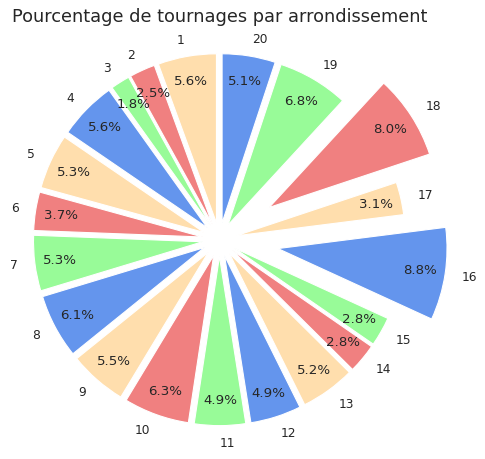

In [35]:
name = [i for i in range(1,21)]
explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.35,0.1,0.35,0.1,0.1,)
colors = ['navajowhite','lightcoral','palegreen','cornflowerblue']

figure = plt.figure(figsize=(13, 7), dpi=80)
plt.title("Pourcentage de tournages par arrondissement",fontsize=16)
plt.pie(df_nbtournage, colors=colors, explode=explode, labels=name, autopct='%1.1f%%', pctdistance=0.85,startangle=90)
plt.show()

On observe un nombre légèrement plus important de tournages dans le 16ème et 18ème arrondissements, avec 8% des tournages. Cela est sûrement lié au fait que ces 2 arrondissements sont assez grands.

Il semblerait que le nombre de tournages augmente légèrement avec l'arrondissement, mais les tournages semblent globalement répartis équitablement entre les arrondissements. Pour vérifier ces observations, nous pouvons tenter d'expliquer le nombre de tournages par la localisation grâce à une **régression linéaire**.

#### Régression linéaire de la localisation sur le nombre de tournages

In [36]:
y_stats = df_paris.groupby('Arrondissement')["Code postal"].count().to_numpy()
X_stats = [i for i in range(1,21)]
X_stats = sm.add_constant(X_stats)

model = sm.OLS(y_stats, X_stats) #nb_tournage (y) en fonction de l'arrondissement (x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2.055
Date:                Wed, 22 Dec 2021   Prob (F-statistic):              0.169
Time:                        14:47:33   Log-Likelihood:                -128.52
No. Observations:                  20   AIC:                             261.0
Df Residuals:                      18   BIC:                             263.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        353.5421     73.184      4.831      0.0

Après étude des résultats de notre régression, nous obtenons un coefficient positif pour l'arrondissement et une constante très élevée. Cependant, la p-value est de 0,169. La variable arrondissement n'est pas significative au seuil de 10%. On en déduit que le nombre de tournages dans la ville de Paris ne peut pas être expliqué par le numéro d'arrondissement du déroulement du tournage.

Même si nous avions une p-value significative, il aurait été évident que l'arrondissement n'est pas suffisant pour décrire le nombre de tournages. Un autre problème est que les arrondissements sont très grands, une étude plus pertinente serait d'étudier Paris divisée en plus petites zones.

### I.2.e. Étude de la répartition des tournages en fonction de leur type : long métrage, série TV, série Web ou téléfilm

Un autre aspect intéressant de notre base de données que nous n'avons pas encore exploré est celui de la répartition des différents types de tournage dans Paris. Il existe 4 types de tournages. On peut supposer que ceux-ci sont répartis différemment dans Paris. Par exemple, le 1er arrondissement pourrait recenser plus de longs métrages que de séries TV ou alors on pourrait retrouver plus de téléfilms tournés dans le 20ème que dans le 8ème arrondissement.

Pour étudier cela, nous allons effectuer une régression linéaire de l'arrondissement sur les indicatrices des quatres types de tournage.

Notre modèle est : num_arrondissement = const + beta1 1(série_TV) + beta2 1(long_métrage) + beta3 1(série_web) + beta4 1(téléfilm) + résidu

On commence par créer un dataframe qui recense les indicatrices par type de tournage :

In [37]:
#On ajoute 4 nouvelles colonnes indicatrices à df_paris, puis on crée df_type_tournage
df_paris = df_paris.assign(Série_TV=df_paris['Type de tournage'].apply(lambda x: 1 if x == 'Série TV' else 0))
df_paris = df_paris.assign(Long_métrage=df_paris['Type de tournage'].apply(lambda x: 1 if x == 'Long métrage' else 0))
df_paris = df_paris.assign(Série_Web=df_paris['Type de tournage'].apply(lambda x: 1 if x == 'Série Web' else 0))
df_paris = df_paris.assign(Téléfilm=df_paris['Type de tournage'].apply(lambda x: 1 if x == 'Téléfilm' else 0))

df_type_tournage = df_paris.iloc[: , [15,16,17,18]].copy() 
df_type_tournage.head()


,Série_TV,Long_métrage,Série_Web,Téléfilm
0,0,1,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [62]:
y_type_tournage = df_paris.Arrondissement.to_numpy()
X_type_tournage = df_type_tournage.to_numpy()
X_type_tournage = sm.add_constant(X_type_tournage)

model_2 = sm.OLS(y_type_tournage, X_type_tournage)
results_2 = model_2.fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     14.78
Date:                Wed, 22 Dec 2021   Prob (F-statistic):           4.85e-12
Time:                        15:00:32   Log-Likelihood:                -28139.
No. Observations:                8910   AIC:                         5.629e+04
Df Residuals:                    8905   BIC:                         5.632e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.384e+13    1.5e+13      0.921      0.3

On remarque que nos variables sont toutes significatives à 1% avec une p-value nulle. Cependant, le R^2 est très faible (0.007), ce qui signifie que le type de tournage ne n'explique pas vraiment la localisation du tournage. Il semblerait donc que le type de tournage ne soit pas corrélé avec l'arrondissement du tournage.

In [39]:
df_inter = df_paris[df_paris["Type de tournage"]=="Série TV"]
print("Série TV : Arrondissement moyen =",df_inter["Arrondissement"].mean())

df_inter = df_paris[df_paris["Type de tournage"]=="Long métrage"]
print("Long métrage : Arrondissement moyen =",df_inter["Arrondissement"].mean())

df_inter = df_paris[df_paris["Type de tournage"]=="Série Web"]
print("Série Web : Arrondissement moyen =",df_inter["Arrondissement"].mean())

df_inter = df_paris[df_paris["Type de tournage"]=="Téléfilm"]
print("Téléfilm : Arrondissement moyen =",df_inter["Arrondissement"].mean())

Série TV : Arrondissement moyen = 10.6217277486911
Long métrage : Arrondissement moyen = 11.339192968437874
Série Web : Arrondissement moyen = 12.738786279683378
Téléfilm : Arrondissement moyen = 11.35820895522388


On retrouve un numéro d'arrondissement en moyenne plus haut pour les tournages de séries Web. Cela se retrouve dans notre régression avec un coefficient plus élevé que les autres (3.52).

### I.2.f. Clustering des tournages en fonction de leur localisation

Nous pouvons utiliser l'algorithme des kmeans pour créer des clusters de nos tournages. À partir des ces clusters, nous pourront visualiser si les tournages sont équitablement répartis dans Paris ou si un (ou plusieurs clusters) contient plus de tournages que les autres.

Tout d'abord, on détermine le nombre optimal de clusters à partir de la méthode Elbow. On teste pour k allant de 2 à 20 (le nombre d'arrondissements). On observe ci-dessous un "coude" à 3 et 4, nous prendrons donc k = 4 par la suite.

In [40]:
from sklearn.cluster import KMeans

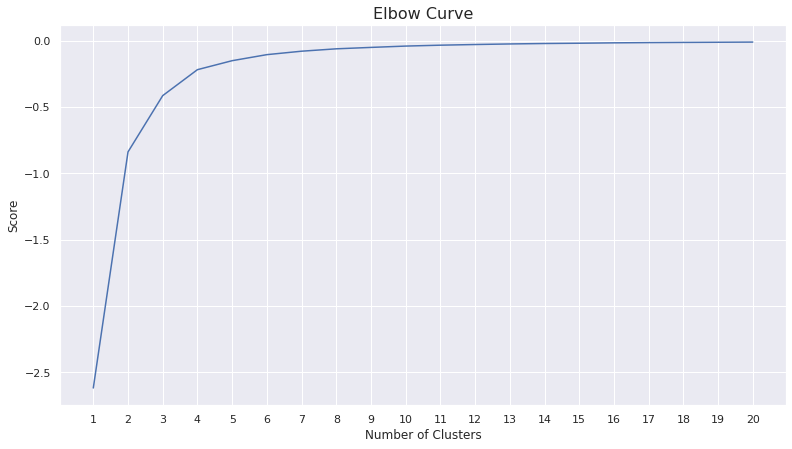

In [41]:
#Elbow method

K_clusters = range(1,21)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_paris[['Coordonnée en Y']]
X_axis = df_paris[['Coordonnée en X']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.figure(figsize = (13,7))
plt.grid(True)
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.xticks(K_clusters)
plt.ylabel('Score')
plt.title('Elbow Curve',fontsize=16)
plt.show()

In [42]:
# Variable avec longitude et latitude
X_kmeans = df_paris.loc[:,['Coordonnée en X','Coordonnée en Y']]
X_kmeans.head(10)

,Coordonnée en X,Coordonnée en Y
0,2.352559,48.830116
1,2.351335,48.842919
2,2.303760,48.877212
3,2.334607,48.821424
4,2.378161,48.829173
5,2.340902,48.881379
6,2.389060,48.868324
7,2.349771,48.882465
8,2.340326,48.889881
9,2.336326,48.878118


In [43]:
# Application de la méthode kmeans pour k = 4
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(X_kmeans[X_kmeans.columns[0:2]]) # Clustering
X_kmeans['cluster_label'] = kmeans.fit_predict(X_kmeans[X_kmeans.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordonnées des centres des clusters
labels = kmeans.predict(X_kmeans[X_kmeans.columns[0:2]])
X_kmeans.head()

,Coordonnée en X,Coordonnée en Y,cluster_label
0,2.352559,48.830116,3
1,2.351335,48.842919,3
2,2.303760,48.877212,2
3,2.334607,48.821424,3
4,2.378161,48.829173,3


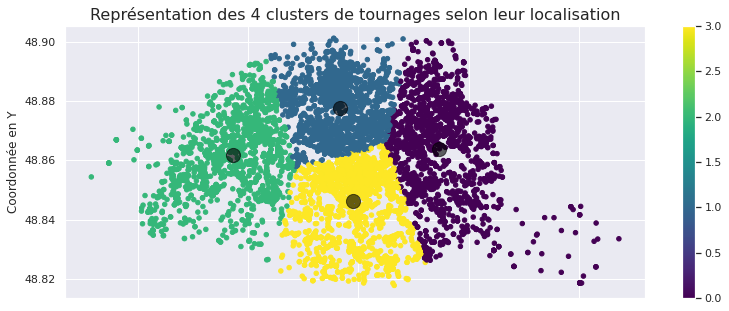

In [44]:
# Visualisation du clustering par la méthode kmeans
X_kmeans.plot.scatter(figsize = (13,5),x = 'Coordonnée en X', y = 'Coordonnée en Y', c=labels, s=20, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.6)
plt.title('Représentation des 4 clusters de tournages selon leur localisation',fontsize=16)
plt.show()

In [45]:
# Calcul du pourcentage de tournages dans chaque cluster

compteur1 = 0
compteur2 = 0
compteur3 = 0
compteur4 = 0
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i]==0 : 
        compteur1+=1
    if kmeans.labels_[i]==1 : 
        compteur2+=1
    if kmeans.labels_[i]==2 : 
        compteur3+=1
    if kmeans.labels_[i]==3 : 
        compteur4+=1

print('Pourcentage de tournages dans le cluster 1 =',round(compteur1/8919*100,2),'%')
print('Pourcentage de tournages dans le cluster 2 =',round(compteur2/8919*100,2),'%')
print('Pourcentage de tournages dans le cluster 3 =',round(compteur3/8919*100,2),'%')
print('Pourcentage de tournages dans le cluster 4 =',round(compteur4/8919*100,2),'%')

Pourcentage de tournages dans le cluster 1 = 23.56 %
Pourcentage de tournages dans le cluster 2 = 28.16 %
Pourcentage de tournages dans le cluster 3 = 21.76 %
Pourcentage de tournages dans le cluster 4 = 26.42 %


Nous pouvons remarquer que les tournages sont globalement équitablement répartis dans chaque cluster. Cela signifie que les tournages de notre base de données sont localisés partout dans Paris, de manière équitable.

Même si la méthode Elbow nous indique que le nombre de cluster idéal est de 4, nous pouvons regarder ce que nous donne l'algorithme pour k = 20, le nombre d'arrondissements, et comparer nos résultats à la vraie carte des arrondissements de Paris.

In [46]:
# Variable avec longitude et latitude
X_kmeans_20 = df_paris.loc[:,['Coordonnée en X','Coordonnée en Y']]

# Application de la méthode kmeans pour k = 20
kmeans_20 = KMeans(n_clusters = 20, init ='k-means++')
kmeans_20.fit(X_kmeans_20[X_kmeans_20.columns[0:2]]) # Clustering
X_kmeans_20['cluster_label'] = kmeans_20.fit_predict(X_kmeans_20[X_kmeans_20.columns[0:2]])
centers = kmeans_20.cluster_centers_ # Coordonnées des centres des clusters
labels = kmeans_20.predict(X_kmeans_20[X_kmeans_20.columns[0:2]])
X_kmeans_20.head()

,Coordonnée en X,Coordonnée en Y,cluster_label
0,2.352559,48.830116,3
1,2.351335,48.842919,13
2,2.303760,48.877212,8
3,2.334607,48.821424,18
4,2.378161,48.829173,17


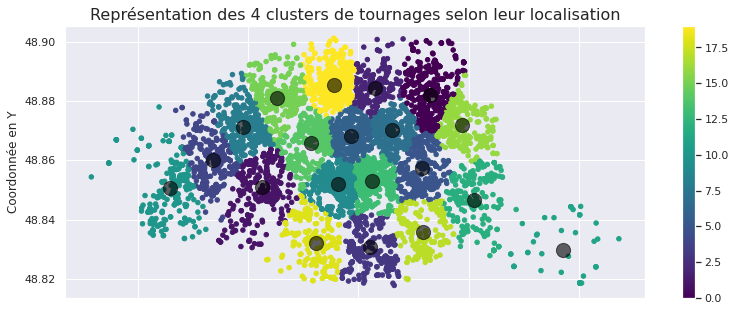

In [47]:
# Visualisation du clustering par la méthode kmeans et comparaison avec la carte des arrondissements parisiens
X_kmeans_20.plot.scatter(figsize = (13,5),x = 'Coordonnée en X', y = 'Coordonnée en Y', c=labels, s=20, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.6)
plt.title('Représentation des 4 clusters de tournages selon leur localisation',fontsize=16)
plt.show()

#### Comparaison avec la carte de la ville de Paris
![carteparis.png](attachment:carteparis.png)

On retrouve quelques arrondissements comme le 15ème, mais cela n'est sûrement dû qu'à la répartition des arrondissements. Par exemple, le 16ème est séparé en 2 clusters sur notre graphique. Comme précédemment, on en ressort que le numéro d'arrondissement n'a pas d'impact sur le nombre de tournages dans celui-ci

### Conclusion partie 1

A rédiger

# II. Analyse de l'impact des lieux culturels sur la répartition des tournages

Si la localisation des tournages ne s'explique pas par le le numéro d'arrondissement ou par letype de tournage, par quoi pourrait-il s'expliquer? 
- Localisation des lieux culturels
- Volumétrie des bâtiments environnants

# III. Analyse de l'impact de l’urbanisme sur la répartition des lieux de tournages

Dans un troisième temps, nous aimerions connaître l'impact de l'urbanisme, et plus particulièrement de l'étendue des bâtiments parisiens sur le nombre de tournages alentours. En effet, par définition de notre jeu de données, les films et séries inclus dans notre base sont réalisés en extérieur. Les bâtiments volumineux de la capitale pourraient donc empêcher certains lieux d'accueillir des tournages, faute d'espace. D'où l'étude de l'impact de la superficie des bâtiments parisiens sur le nombre de tournages selon leur localisation.

## III.1. Introduction d'une nouvelle base de données : les volumes bâtis de la ville de Paris

Pour travailler sur l'impact de l'urbanisme, nous allons utiliser une nouvelle base de données, celle des volumes bâtis de la ville de Paris. Cette base de données, tout comme celle des lieux de tournages, est issue de Paris Data. Elle décrit les bâtiments de manière détaillée en différenciant les bâtis en fonction de leur hauteur et des parties en saillie ou en retrait, définissant ainsi des volumes. Elle comporte 29 colonnes mais nous n'utiliserons que les données :
- geom_x_y → Type : geo_point_2d, Exemple : [48.83996724111359,2.2869880552369186]
- M2 → Type : décimal, Exemple : 6.100362 (Cela correspond à la superficie en m^2 du bâtiment associé)
- N_AR → Type : int, Exemple : 15 (Cela correspond à l'arrondissement où se situe le bâtiment)

In [63]:
df_bat = pd.read_csv('volumesbatisparis-csv.csv',sep=";",engine='python')
df_bat.head()

,geom_x_y,geom,C_NAT_B,L_NAT_B,C_SRC,L_SRC,M2,NB_PL,M2_PL_TOT,B_RDC,C_PLAN_H_I,Y,L_PLAN_H_I,X,D_CRE,L_B_U,D_MAJ,N_AR,L_PLAN_H,H_ET_MAX,N_QU,OBJECTID,Identifiant s?quentiel,Arrondissement contenant le bati,Parcelle contenant le bati,Quartier contenant le bati,AREA,SHAPE.AREA,SHAPE.LEN
0,"48.87201883017173,2.313646308223651","{""coordinates"": [[[2.313609201044077, 48.87203...",V,Volume bâti simple,T,Fiche parcellaire et terrain certifié,13.716794,3.0,41.150383,1.0,2.0,130174.812971,Bâti de 1 à 3 étages,598321.824931,2010-07-21T04:00:00+02:00,NaN,2010-07-21T04:00:00+02:00,8.0,R+2,2.0,31.0,432243.0,750072798.0,75000008.0,750015918.0,750000031.0,NaN,0.0,0.0
1,"48.871385364323665,2.314368155605909","{""coordinates"": [[[2.314378581981666, 48.87140...",U,Volume bâti avec surplomb,T,Fiche parcellaire et terrain certifié,7.123717,1.0,7.123717,0.0,2.0,130104.341394,Bâti de 1 à 3 étages,598374.753577,2010-07-21T04:00:00+02:00,encorbt_au_1,2010-07-21T04:00:00+02:00,8.0,NaN,1.0,31.0,432264.0,750071312.0,75000008.0,750013681.0,750000031.0,NaN,0.0,0.0
2,"48.87151569854604,2.314590202677058","{""coordinates"": [[[2.314532345365845, 48.87158...",V,Volume bâti simple,T,Fiche parcellaire et terrain certifié,164.434864,6.0,986.609184,1.0,3.0,130117.789846,Bâti de 4 à 8 étages,598391.219335,2010-07-21T04:00:00+02:00,NaN,2010-07-21T04:00:00+02:00,8.0,R+5,5.0,31.0,432270.0,750071318.0,75000008.0,750013681.0,750000031.0,NaN,0.0,0.0
3,"48.871701531060445,2.3157547319914755","{""coordinates"": [[[2.315764408713301, 48.87175...",V,Volume bâti simple,T,Fiche parcellaire et terrain certifié,61.962012,6.0,371.772070,1.0,3.0,130140.229093,Bâti de 4 à 8 étages,598477.140907,2010-07-21T04:00:00+02:00,NaN,2010-07-21T04:00:00+02:00,8.0,R+5,5.0,31.0,432335.0,750071600.0,75000008.0,750015313.0,750000031.0,NaN,0.0,0.0
4,"48.871676088638765,2.315846925736624","{""coordinates"": [[[2.3158668633263773, 48.8716...",V,Volume bâti simple,T,Fiche parcellaire et terrain certifié,6.442048,5.0,32.210238,1.0,3.0,130136.653373,Bâti de 4 à 8 étages,598483.239658,2010-07-21T04:00:00+02:00,NaN,2010-07-21T04:00:00+02:00,8.0,R+4,4.0,31.0,432349.0,750071614.0,75000008.0,750015313.0,750000031.0,NaN,0.0,0.0


### III.1.a. Étude préalable de la base de données des bâtiments de la ville de Paris

On commence par restreindre notre base de données aux variables qui nous intéressent.

In [64]:
df_bat = df_bat[["geom_x_y","M2","N_AR"]]
df_bat.head()

,geom_x_y,M2,N_AR
0,"48.87201883017173,2.313646308223651",13.716794,8.0
1,"48.871385364323665,2.314368155605909",7.123717,8.0
2,"48.87151569854604,2.314590202677058",164.434864,8.0
3,"48.871701531060445,2.3157547319914755",61.962012,8.0
4,"48.871676088638765,2.315846925736624",6.442048,8.0


Avant de traiter plus en détail notre jeu de données, on regarde s'il contient des NaN ou des données aberrantes.

In [65]:
df_bat.isnull().sum()

geom_x_y    3
M2          1
N_AR        1
dtype: int64

In [66]:
df_bat[df_bat['M2']>20000]

,geom_x_y,M2,N_AR
177331,"48.83224835397238,2.2842950532455535",39818.661131,15.0
197721,"48.89569276899732,2.3879909675078403",21787.000169,19.0
198516,"48.898075678426274,2.3753505404128434",27754.802585,19.0
205867,"48.8809812788448,2.355391158012136",24257.871265,10.0
270387,"48.89787161190764,2.3667847490728033",27987.667337,18.0


Notre base de données ne contient pas de NaN, mais on observe un bâtiment dont la superficie dépasse les 160 000 m2. Après avoir vérifié sur Google Maps avec les coordonnées associées, il semblerait que cette valeur soit erronnée. On supprime cette ligne.

In [67]:
df_bat.drop(df_bat[df_bat['M2']>160000].index, inplace=True)
df_bat.reset_index(inplace=True, drop=True) # On réinitialise les index après suppression d'une ligne

### III.1.b. Analyse de la superficie totale construite selon l'arrondissement

On va commencer par étudier la taille des bâtiments en fonction des arrondissements parisiens. On observera si certains arrondissements contiennent plus de constructions que d'autres. On peut supposer au préalable que dans les arrondissements où il y a beaucoup de bâtiments volumineux, il y a moins de tournages, faute d'espace.

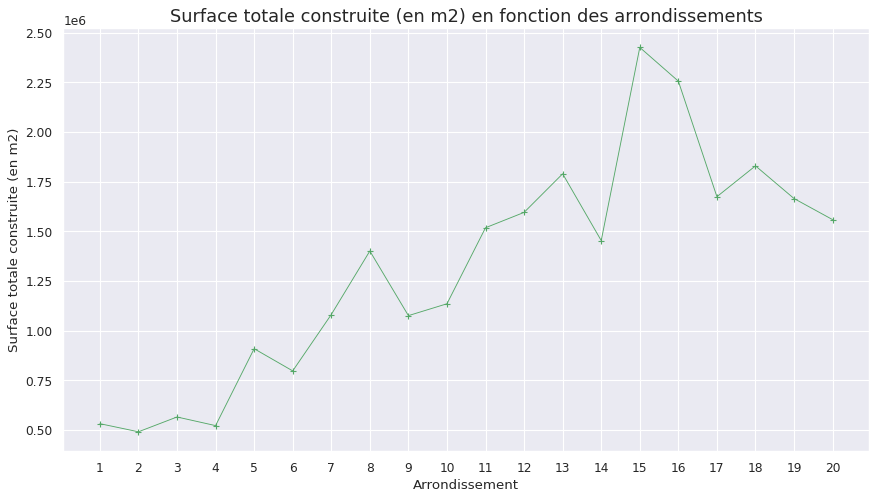

In [68]:
df_surface = df_bat.groupby('N_AR')["M2"].agg([pd.Series.sum])

figure = plt.figure(figsize=(13, 7), dpi=80)
plt.grid(True)
arrondissement = [i for i in range(1,21)]

plt.plot(df_surface, "g", linewidth=0.8, marker="+")
plt.xlabel('Arrondissement')
plt.xticks(arrondissement)
plt.ylabel('Surface totale construite (en m2)')
plt.title('Surface totale construite (en m2) en fonction des arrondissements',fontsize=16)
plt.show()

Nous pouvons relever que les arrondissements ayant les surfaces construites les plus conséquentes sont le 16ème et le 18ème arrondissements. Nous avions vu dans la première partie que ces 2 arrondissements recensaient également le plus grand nombre de tournages. Cependant, ces arrondissements étant assez étendus, on peut se demander si nos résultats sont seulement liés à la taille conséquente de ces arrondissements ou s'il y a réellement un effet de causalité. Pour vérifier cela, nous pouvons dans un premier temps regarder la surface totale construite "normalisée" par la superficie de l'arrondissement en fonction de l'arrondissement.

Pour se faire, nous avons besoin des superficies des différents arrondissements parisiens. Nous allons récupérer ces données avec du webscrapping, à l'aide du package BeautifulSoup.

#### Webscrapping des superficies des arrondissements parisiens

In [69]:
import urllib
import bs4
from urllib import request

In [70]:
url_arrondissement = "https://fr.vikidia.org/wiki/Arrondissements_de_Paris"
request_text = request.Request('https://fr.vikidia.org/wiki/Arrondissements_de_Paris', headers={'User-Agent': 'Mozilla/5.0'})
webpage = request.urlopen(request_text).read()

In [71]:
page = bs4.BeautifulSoup(webpage, "lxml")
table = page.find("table")
table_body = table.find('tbody')
rows = table_body.find_all('tr')
cols = rows[1].find_all('td')

superficie_arr = []

for row in rows[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    superficie_arr.append(float(cols[1]))

#Superficie des 20 arrondissements dans superficie_arr

# Dictionnaire des arrondissements ayant comme valeur leur superficie
dico_participants = dict()
for row in rows[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0 : 
        dico_participants[cols[0]] = float(cols[1])
dico_participants

{'Paris 10e arrondissement': 289.0,
 'Paris 11e arrondissement': 367.0,
 'Paris 12e arrondissement': 637.0,
 'Paris 13e arrondissement': 715.0,
 'Paris 14e arrondissement': 564.0,
 'Paris 15e arrondissement': 848.0,
 'Paris 16e arrondissement': 791.0,
 'Paris 17e arrondissement': 567.0,
 'Paris 18e arrondissement': 601.0,
 'Paris 19e arrondissement': 679.0,
 'Paris 1er arrondissement': 183.0,
 'Paris 20e arrondissement': 598.0,
 'Paris 2e arrondissement': 99.0,
 'Paris 3e arrondissement': 117.0,
 'Paris 4e arrondissement': 160.0,
 'Paris 5e arrondissement': 254.0,
 'Paris 6e arrondissement': 215.0,
 'Paris 7e arrondissement': 409.0,
 'Paris 8e arrondissement': 388.0,
 'Paris 9e arrondissement': 218.0}

On retrouve ci-dessus un dictionnaire des arrondissements avec leur superficie. Après obtention de ces superficies, on normalise les surfaces totales construites.

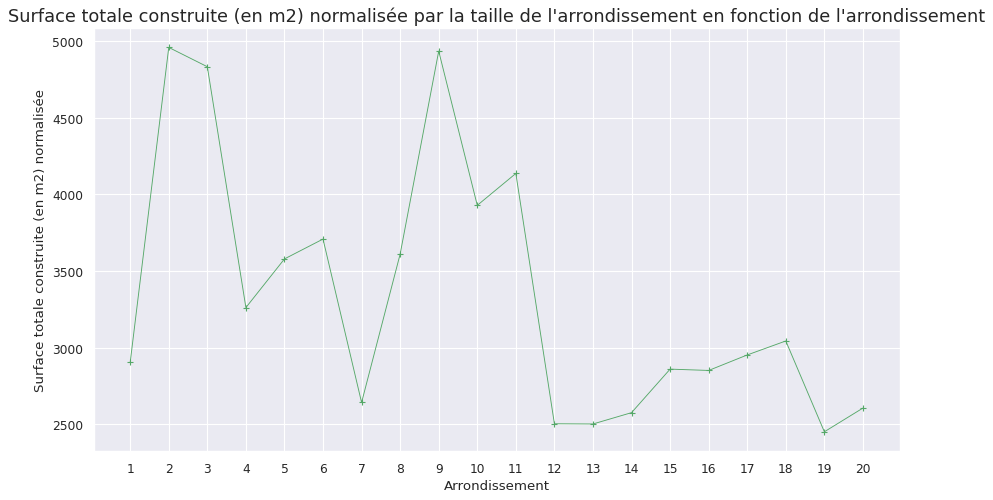

In [72]:
df_surface_new = df_bat.groupby('N_AR')["M2"].agg([pd.Series.sum])
df_surface_new = df_surface_new['sum']/superficie_arr # Normalisation

figure = plt.figure(figsize=(13, 7), dpi=80)
plt.grid(True)
arrondissement = [i for i in range(1,21)]

plt.plot(df_surface_new, "g", linewidth=0.8, marker="+")
plt.xlabel('Arrondissement')
plt.xticks(arrondissement)
plt.ylabel('Surface totale construite (en m2) normalisée')
plt.title("Surface totale construite (en m2) normalisée par la taille de l'arrondissement en fonction de l'arrondissement",fontsize=16)
plt.show()

Le graphique change totalement, désormais le 9ème arrondissement est celui qui recense la surface la plus dense de construction. Cela peut sembler logique, on y trouve de grands bâtiments tels que le musée Grévin, l'opéra Garnier, le Printemps Haussmann, ainsi que de nombreux hôtels, immeubles.

##### A modifier (3,4,9 et 11 et pas que 9)

## III.2. Étude de l'impact de la superficie des bâtiments parisiens sur le nombre de tournages

Notre but premier était d'étudier l'impact de la superficie des bâtiments parisiens sur le nombre de tournages, étant donnée une localisation. C'est-à-dire : "Dans cette zone-ci, il y a x tournages et y m2 de bâtiments. Est-ce que y a un impact sur x ?"

Nous voulons désormais relier nos 2 bases de données. Nous allons, dans un premier temps, rapprocher les jeux de données via un attribut commun : l'arrondissement (Arrondissement et N_AR) et étudier l'impact de la superficie des bâtiments parisiens sur le nombre de tournages, étant donné l'arrondissement. 

Cependant, les arrondissements sont des zones très étendues et peut-être trop grandes pour notre étude. Dans un second temps, nous étudierons l'impact de la superficie des bâtiments parisiens sur le nombre de tournages, étant données de plus petites zones d'étude que nous tenterons de définir.



### III.2.a. Analyse de l'impact de la superficie des bâtiments parisiens sur le nombre de tournages à partir des arrondissements

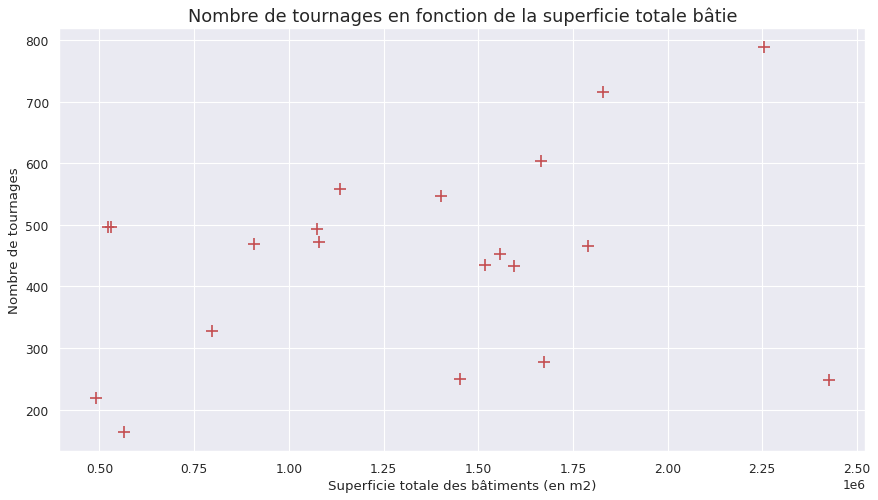

In [73]:
figure = plt.figure(figsize=(13, 7), dpi=80)
df_nbtournage = df_paris.groupby('Arrondissement')["Code postal"].count()

plt.grid(True)
plt.scatter(df_surface,df_nbtournage,s=100,marker='+',color='r')
plt.ylabel('Nombre de tournages')
plt.xlabel('Superficie totale des bâtiments (en m2)')
plt.title('Nombre de tournages en fonction de la superficie totale bâtie',fontsize=16)
plt.show()


La question que l'on se pose est : Est-ce qu'il y a moins de tournages dans les zones très urbanisées et construites ?
Graphiquement, cela semble être le contraire, il semble y avoir plus de tournages dans les arrondissements avec les bâtiments les plus vastes. 

Il se pourrait qu'un nombre de tournages et une superficie totale construite élevé ne soient seulement dus à la grande superficie d'un arrondissement.

On peut tout de même effectuer une régression linéaire pour étudier la pertinence de notre modèle.

In [74]:
# Régression : nb_tournage = alpha + beta*superficie_bat + résidu

X_stats_superficie = sm.add_constant(df_surface.to_numpy())
y_stats_superficie = df_nbtournage.to_numpy()

model_3 = sm.OLS(y_stats_superficie,X_stats_superficie)
results_3 = model_3.fit()
print(results_3.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.016
Date:                Wed, 22 Dec 2021   Prob (F-statistic):              0.173
Time:                        16:01:27   Log-Likelihood:                -128.54
No. Observations:                  20   AIC:                             261.1
Df Residuals:                      18   BIC:                             263.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        326.6821     90.818      3.597      0.0

Notre coefficient R^2 est faible mais pas aberrant (0.205), il est plus élevé que lors de nos précédentes régressions. Contre toute attente, le coefficient de la superficie totale des bâtiments est significatif au seuil de 5% mais il est très faible, de l'ordre de 0.0005. Nous pensons qu'il n'est pas pertinent de conclure avec une telle régression car celle-ci se base seulement sur 20 données, le nombre d'arrondissements. Nous voulons donc étudier l'impact de la superficie des bâtiments sur le nombre de tournages, à partir de zones plus petites et équitablement réparties.

### III.2.b. Analyse de l'impact de la superficie des bâtiments parisiens sur le nombre de tournages à partir de plus petites zones que les arrondissements

Dans cette partie, nous allons tenter de découper Paris en zones nettement plus petites que les arrondissements. Notre résultat n'est pas parfait mais nous allons tout de même détailler notre cheminement.

Tout d'abord, on veut découper Paris en différentes zones, mais combien de zones ? Nous allons commencer avec un ordre de grandeur de 10^3.

In [75]:
# On définit les minima et maxima de nos coordonnées en X et Y des tournages
min_X = df_paris["Coordonnée en X"].min()
max_X = df_paris["Coordonnée en X"].max()
min_Y = df_paris["Coordonnée en Y"].min()
max_Y = df_paris["Coordonnée en Y"].max()

# On définit notre plage de coordonnées, c'est-à-dire l'étendue de notre étude
dist_X = max_X - min_X
dist_Y = max_Y - min_Y

# On définit 1600 zones équitablement réparties
echelle_X, echelle_Y = dist_X/40,dist_Y/40

tab_X = np.arange(min_X,max_X,echelle_X) #de taille 40
tab_Y = np.arange(min_Y,max_Y,echelle_Y) #de taille 40

# On crée une grille de taille 40x40 qui représente nos 1600 zones
X_zones, Y_zones = np.meshgrid(tab_X, tab_Y)


On veut superposer notre grille sur la carte de Paris. Nous avons utiliser un fichier csv qui fournit les frontières administratives de toutes les communes de France. Nous restreignons cette base de données à Paris, pour récupérer les délimitations de la capitale.

In [91]:
# Récupération des coordonnées des contours administratifs de Paris
idf = pd.read_csv('idf.csv',sep=";",engine='python')
idf['code_departement'] = idf['code_departement'].astype(str)
idf_paris = idf[idf["code_departement"].str.startswith("75")]
coordonnees = idf_paris['coordinates'].tolist()
new_coord = coordonnees[0].split(",")
new_coord = [float(i) for i in new_coord] # contient les coordonnées de points définissant les frontières de Paris

In [92]:
# Aperçu de la base de données utilisée (variable utile : 'coordinates')
idf_paris

,latitude,longitude,altitude,geometry,coordinates,code_epci,commune,code_insee_region,code_ancienne_region,region,code_commune,departement,geo_point,code_departement,epci,ancienne_region,intitule_commune
303,NaN,NaN,NaN,Polygon,"2.364204281172879,48.81639832398714,2.36332892...",200054781,Paris,11,11,Île-de-France,75056,Paris,"48.8566151882,2.3429151332",75,Métropole du Grand Paris,Île-de-France,75056 Paris


In [93]:
# On récupére dans 2 listes distinctes les latitudes et longitudes des points de la frontière
x_coord_paris = []
y_coord_paris = []
for i in range(len(new_coord)) :
    if i%2!=0 :
        y_coord_paris.append(new_coord[i])
    else :
        x_coord_paris.append(new_coord[i])


D'où le graphique suivant. Les frontières de Paris sont dessinées en bleu grâce à notre dataframe idf_paris. Nos zones d'étude (en rouge) sont numérotées de 1 à 100 à titre d'exemple ci-dessous. Dans notre vraie modèle, nous découpons Paris en 1600 zones.

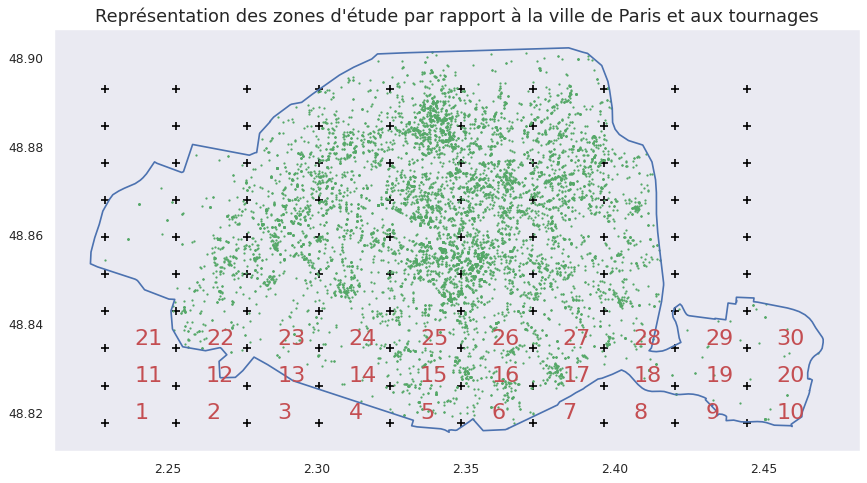

In [94]:
# Exemple avec 100 zones
echelle_X_exemple, echelle_Y_exemple = dist_X/10,dist_Y/10
tab_X_exemple = np.arange(min_X,max_X,echelle_X_exemple) #de taille 10
tab_Y_exemple = np.arange(min_Y,max_Y,echelle_Y_exemple) #de taille 10
X_zones_exemple, Y_zones_exemple = np.meshgrid(tab_X_exemple, tab_Y_exemple)

plt.figure(figsize=(13, 7), dpi=80)

# On affiche les premiers numéros de zones (pour visualiser où elles se trouvent)
for j in range(1,4):
    for i in range(1,11):
        plt.annotate(i+(j-1)*10, xy = (tab_X_exemple[i-1],tab_Y_exemple[j-1]), xytext = (tab_X_exemple[i-1]+0.01,tab_Y_exemple[j-1]+0.001),fontsize=20,color='r')

plt.scatter(X_zones_exemple,Y_zones_exemple,s=50,marker='+',c='black')
plt.grid(False)
plt.plot(x_coord_paris,y_coord_paris)
plt.scatter(df_paris['Coordonnée en X'],df_paris['Coordonnée en Y'],s=1,color='g')
plt.title("Représentation des zones d'étude par rapport à la ville de Paris et aux tournages",fontsize=16)
plt.show()


#### Création d'un tableau qui recense le nombre de tournages par zone (tab_zone_1600)

In [95]:
# On numérote les zones de 1 à 1600 de gauche à droite et de bas en haut

# On implémente 2 fonctions qui vont nous permettre de déterminer dans quelle zone se trouve le point de coordonnées coord_point
def zone_point_x(coord_point):
    zone_indice_x = 0
    for i in range(len(tab_X)):
    #si la coord en x inf à celle des zones, on s'arrête
        if coord_point[0] < tab_X[i]:
            zone_indice_x = i
            return(zone_indice_x)
        #sinon on continue

def zone_point_y(coord_point):
    zone_indice_y = 0
    for i in range(len(tab_Y)):
    #si la coord en y inf à celle des zones, on s'arrête
        if coord_point[1] < tab_Y[i]:
            zone_indice_y = i
            return(zone_indice_y)
        #sinon on continue

coord_tournage = df[['Coordonnée en X','Coordonnée en Y']].to_numpy()

# La ligne ci-dessous renvoie le numéro de la zone du premier tournage
num_zone = zone_point_x(coord_tournage[0])+((zone_point_y(coord_tournage[0])-1)*40)
print("Le premier point se trouve dans la zone",num_zone,'.')


Le premier point se trouve dans la zone 221 .


In [96]:
# On trouve la zone pour chaque point du tournage et on ajoute +1 à leur indice dans un tableau de taille 1600

tab_zone_1600 = np.zeros(1600)

for i in coord_tournage:
  #lever une exception sur le pt 2395 car zone_point_x(coord_tournage[2395]) est un NoneType
  if type(zone_point_y(i))==int and type(zone_point_x(i))==int:
    xaxis = zone_point_x(i)
    yaxis = zone_point_y(i)
    num_zone = xaxis + (yaxis-1)*40 
    tab_zone_1600[num_zone]+=1

print("Il y a eu",int(tab_zone_1600[654]),"tournages dans la zone 654.")

Il y a eu 13 tournages dans la zone 654.


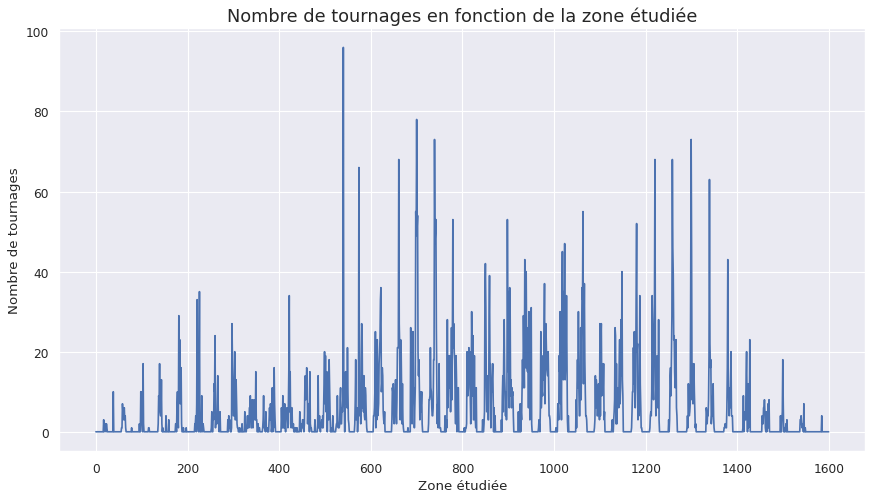

In [97]:
# On représente le nombre de tournages par zone

plt.figure(figsize=(13, 7), dpi=80)
plt.plot(tab_zone_1600)
plt.title('Nombre de tournages en fonction de la zone étudiée',fontsize=16)
plt.ylabel('Nombre de tournages')
plt.xlabel('Zone étudiée')
plt.show()

#### A analyser

#### Création d'un tableau qui recense la surface totale construite par zone (surface_zone)

On étudie ensuite de la même manière la superficie totale de bâtiments construits en fonction de la zone étudiée (de 1 à 1600).

In [106]:
# Les fonctions suivantes vont nous permettre de déterminer dans quelle zone se trouve le bâtiment de coordonnées coord_bat
# (Attention les coordonnées d'un bâtiment sont dans l'autre sens : y,x)

def zone_point_x_bat(coord_bat):
    zone_indice_x = 0
    for i in range(len(tab_X)):
        #si la coord en x inf à celle des zones, on s'arrête
        if coord_bat[1] < tab_X[i]:
            zone_indice_x = i
            return(zone_indice_x)
        #sinon on continue

def zone_point_y_bat(coord_bat):
    zone_indice_y = 0
    for i in range(len(tab_Y)):
        #si la coord en y inf à celle des zones, on s'arrête
        if coord_bat[0] < tab_Y[i]:
            zone_indice_y = i
            return(zone_indice_y)
        #sinon on continue

surface_zone = np.zeros(1600)
coord_bat = df_bat['geom_x_y'].to_numpy()

#on transforme les coordonnées en float
for i in range(len(coord_bat)):
    coord_bat[i] = coord_bat[i].split(",")
    coord_bat[i] = [float(y) for y in coord_bat[i]]

# On ajoute les surfaces dans surface_zone
for i in range(len(coord_bat)):
  #lever une exception car 275 coordonnées sont des NoneTypes
  if type(zone_point_x_bat(coord_bat[i]))==int and type(zone_point_y_bat(coord_bat[i]))==int:
    xaxis_bat = zone_point_x_bat(coord_bat[i])
    yaxis_bat = zone_point_y_bat(coord_bat[i])
    num_zone_bat = xaxis_bat + (yaxis_bat-1)*40
    surface_zone[num_zone_bat]+=df_bat["M2"][i]
    #print(num_zone_bat,df_bat["M2"][i])
    

TypeError: ignored

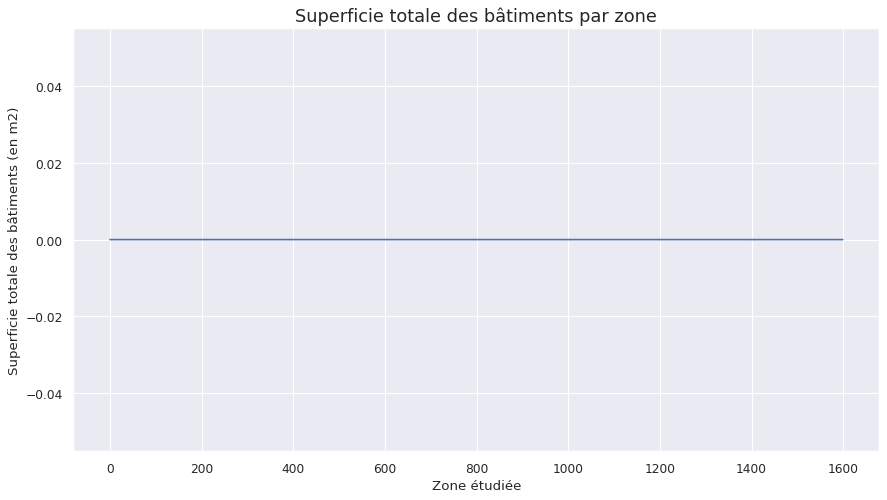

In [99]:
# On représente la superficie totale de bâtiments par zone

plt.figure(figsize=(13, 7), dpi=80)
plt.plot(surface_zone)
plt.title('Superficie totale des bâtiments par zone',fontsize=16)
plt.ylabel('Superficie totale des bâtiments (en m2)')
plt.xlabel('Zone étudiée')
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in true_divide



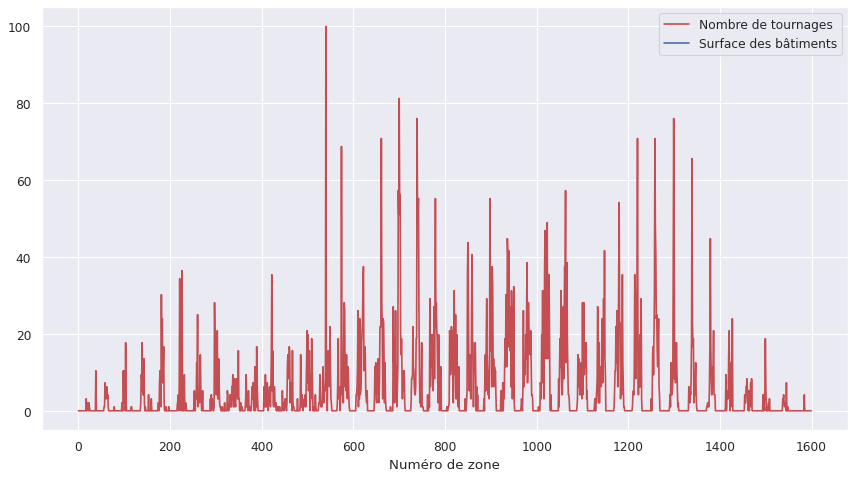

In [100]:
# On normalise nos graphiques pour pouvoir les comparer

figure = plt.figure(figsize=(13, 7), dpi=80)
myPlota, = plt.plot(tab_zone_1600/max(tab_zone_1600)*100,color='r')
myPlotb, = plt.plot(surface_zone/max(surface_zone)*100)
plt.legend([myPlota, myPlotb], ["Nombre de tournages","Surface des bâtiments"])
plt.xlabel("Numéro de zone")
plt.show()

#### Suppression des zones en dehors de Paris

On se rend bien compte en superposant notre grille de zones et la carte de Paris que plusieurs de nos zones ne se trouvent pas dans Paris. C'est d'ailleurs pourquoi dans les graphiques précédents, beaucoup de nos valeurs se trouvent à 0. Afin de pallier à ce problème, nous allons supprimer les zones où la superficie bâtie est nulle, elles correspondent à nos zones en dehors de Paris dans notre grille.

In [101]:
# On supprime les zones où la superficie bâtie est nulle

indice_zone_à_supprimer = []

for i in range(len(surface_zone)):
    if surface_zone[i]==0:
        indice_zone_à_supprimer.append(i)

print(len(indice_zone_à_supprimer),"zones de notre grille se trouvaient en dehors de Paris.")


1600 zones de notre grille se trouvaient en dehors de Paris.


In [102]:
# Nouveaux tableaux, avec le nombre de tournages et la superficie bâtie dans nos zones à l'intérieur de Paris
surface_zone = list(surface_zone)
tab_zone_1600 = list(tab_zone_1600)

for i in range(len(indice_zone_à_supprimer)-1,-1,-1):
    del surface_zone[indice_zone_à_supprimer[i]]
    del tab_zone_1600[indice_zone_à_supprimer[i]]
    

#### Visualisation du nombre de tournages en fonction de la superficie totale bâtie

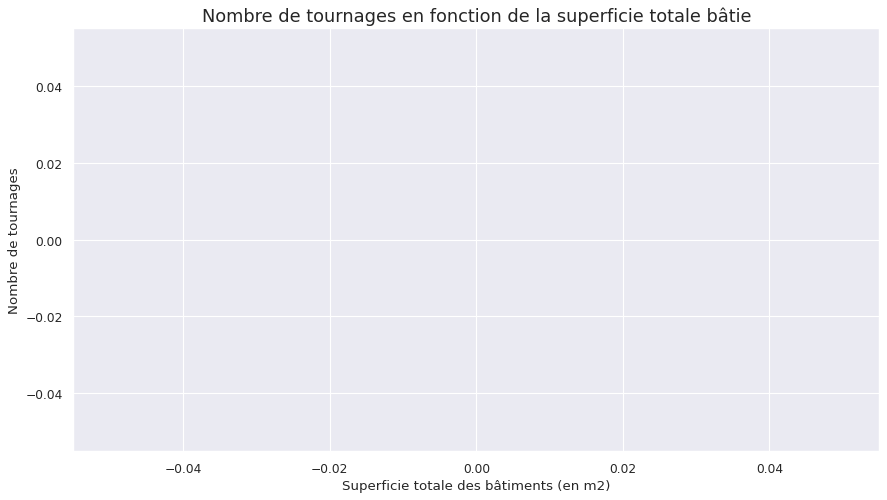

In [103]:
figure = plt.figure(figsize=(13, 7), dpi=80)
plt.grid(True)
plt.scatter(surface_zone,tab_zone_1600,s=40,marker='+',color='r')
plt.ylabel('Nombre de tournages')
plt.xlabel('Superficie totale des bâtiments (en m2)')
plt.title('Nombre de tournages en fonction de la superficie totale bâtie',fontsize=16)
plt.show()


### A analyser

On observe quelques valeurs extrêmes dues à la présence de très grands bâtiments. On visualise ci-dessous où se situe la zone ayant la surface construite la plus importante (environ 70000m2). A l'aide des coordonnées GPS, on peut supposer qu'elle contient notamment l'opéra Bastille

IndexError: ignored

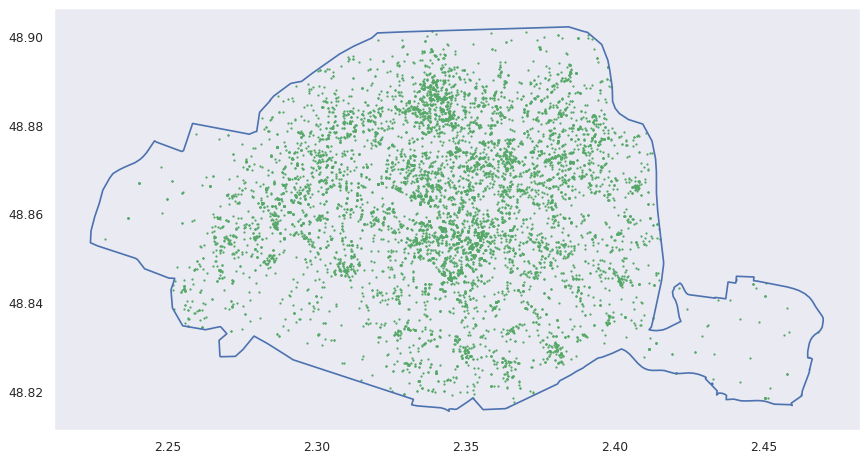

In [104]:
# Représentation de la zone où se trouve 70000 m2 de bâtiments

coord_sup_70000 = df_bat[df_bat['M2']>50000].geom_x_y.to_numpy()

plt.figure(figsize=(13, 7), dpi=80)
plt.scatter
plt.grid(False)
plt.plot(x_coord_paris,y_coord_paris)
plt.scatter(df_paris['Coordonnée en X'],df_paris['Coordonnée en Y'],s=1,color='g')
plt.scatter(coord_sup_70000[0][1],coord_sup_70000[0][0],s=150,marker='o',c='red')
plt.annotate("Zone la plus bâtie", xy = (coord_sup_70000[0][1],coord_sup_70000[0][0]), xytext = (coord_sup_70000[0][1]+0.02,coord_sup_70000[0][0]+0.02),fontsize=19,color='red',arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='right', verticalalignment='top',)
plt.title("Représentation de la zone où se trouve 70 000 m2 de bâtiments",fontsize=16)
plt.show()


#### Régression linéaire de la superficie des bâtiments sur le nombre de tournages

On effectue finalement une régression linéaire de la superficie des bâtiments sur le nombre de tournages.

In [105]:
# Régression : nb_tournage = alpha + beta*superficie_bat + résidu

X_stats_superficie_zones = sm.add_constant(surface_zone)
y_stats_superficie_zones = tab_zone_1600

model_4 = sm.OLS(y_stats_superficie_zones,X_stats_superficie_zones)
results_4 = model_4.fit()
print(results_4.summary())


ValueError: ignored

### A analyser

etude similaire à celles des arrondissements
r2 plus petit
variable significative
plus pertinent que précédemment, utile d'avoir fait de plus petites zones

# Conclusion

parler des limites du modèle